In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

In [3]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

# Read the CSV and Perform Basic Data Cleaning

In [4]:
# https://help.lendingclub.com/hc/en-us/articles/215488038-What-do-the-different-Note-statuses-mean-

columns = [
    "loan_amnt", "int_rate", "installment", "home_ownership",
    "annual_inc", "verification_status", "issue_d", "loan_status",
    "pymnt_plan", "dti", "delinq_2yrs", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc",
    "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
    "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq",
    "tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il",
    "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
    "all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
    "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
    "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc",
    "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
    "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit", "hardship_flag", "debt_settlement_flag"
]

target = ["loan_status"]

In [5]:
# Load the data
file_path = Path('../classification_homework_uw_fintech/Resources/LoanStats_2019Q1.csv.zip')
df = pd.read_csv(file_path, skiprows=1)[:-2]
df = df.loc[:, columns].copy()

# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()

# Remove the `Issued` loan status
issued_mask = df['loan_status'] != 'Issued'
df = df.loc[issued_mask]

# convert interest rate to numerical
df['int_rate'] = df['int_rate'].str.replace('%', '')
df['int_rate'] = df['int_rate'].astype('float') / 100


# Convert the target column values to low_risk and high_risk based on their values
x = {'Current': 'low_risk'}   
df = df.replace(x)

x = dict.fromkeys(['Late (31-120 days)', 'Late (16-30 days)', 'Default', 'In Grace Period'], 'high_risk')    
df = df.replace(x)

df.reset_index(inplace=True, drop=True)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,next_pymnt_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,0.0,0.0,8.0,0.0,1609.0,14.0,w,10204.87,10204.87,355.29,355.29,295.13,60.16,0.0,0.0,0.0,375.35,May-2019,0.0,1.0,Individual,0.0,178.0,38199.0,3.0,4.0,2.0,4.0,3.0,36590.0,59.0,1.0,2.0,1553.0,58.0,3700.0,1.0,0.0,4.0,6.0,4775.0,447.0,77.7,0.0,0.0,93.0,96.0,3.0,3.0,0.0,20.0,1.0,0.0,1.0,2.0,1.0,1.0,10.0,3.0,3.0,2.0,8.0,0.0,0.0,0.0,3.0,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,0.0,0.0,17.0,1.0,18368.0,34.0,w,24293.13,24293.13,873.53,873.53,706.87,166.66,0.0,0.0,0.0,929.09,May-2019,0.0,1.0,Individual,0.0,165.0,228119.0,3.0,3.0,2.0,3.0,4.0,42273.0,86.0,4.0,8.0,5197.0,61.0,50400.0,4.0,9.0,3.0,13.0,13419.0,29502.0,28.4,0.0,0.0,87.0,286.0,1.0,1.0,2.0,1.0,11.0,3.0,7.0,11.0,8.0,13.0,14.0,13.0,18.0,11.0,17.0,0.0,0.0,0.0,6.0,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,0.0,0.0,8.0,0.0,13247.0,21.0,w,19636.79,19636.79,485.44,485.44,363.21,122.23,0.0,0.0,0.0,529.88,May-2019,0.0,1.0,Individual,0.0,0.0,45684.0,2.0,3.0,2.0,3.0,4.0,32437.0,75.0,2.0,3.0,2810.0,75.0,17500.0,0.0,4.0,1.0,6.0,5711.0,2839.0,62.1,0.0,0.0,159.0,156.0,7.0,4.0,0.0,7.0,7.0,6.0,2.0,5.0,2.0,7.0,8.0,5.0,13.0,5.0,8.0,0.0,0.0,0.0,4.0,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,0.0,1.0,10.0,1.0,17996.0,23.0,w,9719.34,9719.34,335.33,335.33,280.66,54.67,0.0,0.0,0.0,353.55,May-2019,0.0,1.0,Individual,0.0,0.0,68784.0,0.0,4.0,1.0,3.0,9.0,50788.0,66.0,0.0,1.0,6360.0,69.0,23000.0,3.0,5.0,4.0,4.0,6878.0,4899.0,75.1,0.0,0.0,100.0,89.0,24.0,9.0,0.0,34.0,0.0,0.0,4.0,6.0,4.0,4.0,17.0,6.0,6.0,6.0,10.0,0.0,0.0,0.0,1.0,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,0.0,1.0,14.0,0.0,9091.0,28.0,w,21614.73,21614.73,484.36,484.36,385.27,99.09,0.0,0.0,0.0,520.39,May-2019,0.0,1.0,Individual,0.0,0.0,177745.0,0.0,1.0,0.0,2.0,14.0,16828.0,84.0,1.0,1.0,3600.0,41.0,43100.0,2.0,0.0,2.0,4.0,13673.0,19699.0,28.6,0.0,0.0,67.0,138.0,11.0,11.0,4.0,11.0,0.0,0.0,4.0,6.0,7.0,11.0,6.0,12.0,18.0,6.0,14.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


# Split the Data into Training and Testing

In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
# Create our features
# YOUR CODE HERE
loans_df = pd.get_dummies(df, columns = ['home_ownership', 'verification_status', 'issue_d', 'pymnt_plan', 'initial_list_status', 'next_pymnt_d', 'application_type', 'hardship_flag', 'debt_settlement_flag'])
loans_df.head()

x_cols = [i for i in loans_df.columns if i not in ('loan_status')]
X = loans_df[x_cols]
# Create our target
# YOUR CODE HERE
y = loans_df['loan_status']

In [7]:
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,issue_d_Feb-2019,issue_d_Jan-2019,issue_d_Mar-2019,pymnt_plan_n,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,68817.0,68817.000000,68817.000000,68817.0,68817.0,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.00000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,68817.0,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,6.881700e+04,6.881700e+04,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,68817.0
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,24.666347,16018.845833,16015.919519,970.639473,970.431151,658.748750,311.855687,0.035072,0.0,0.0,517.202218,0.016188,1.0,0.0,188.664298,1.634976e+05,1.023047,3.290481,0.843730,1.909644,14.303152,4.324044e+04,69.21191,1.240042,2.622245,6297.491710,55.702472,42431.895360,1.382071,1.687795,2.189023,4.827572,14142.936193,16991.852667,48.330667,0.006830,2.347065,125.468605,175.136841,14.294215,7.179781,1.441882,24.714954,7.688028,0.472485,3.806123,5.648038,5.135156,7.414403,9.500153,8.630818,13.517663,5.653036,12.571995,0.0,0.0,0.052138,2.219423,95.057627,30.626217,0.125972,0.0,2.100332e+05,6.133843e+04,29734.128558,5.572240e+04,0.009285,0.526309,0.106747,0.357659,0.478007,0.373992,0.148001,0.371696,0.451066,0.177238,1.0,0.123879,0.876121,0.383161,0.616839,0.860340,0.139660,1.0,1.0
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,12.318917,10002.695495,10004.985940,1229.563301,1229.569864,1126.237377,279.786954,1.086720,0.0,0.0,816.021053,0.134774,0.0,0.0,1808.457195,1.723699e+05,1.176782,2.965579,0.970543,1.544994,13.972619,4.956130e+04,22.33711,1.471745,2.502608,5702.281757,18.495480,37166.229316,1.543220

In [8]:
# Check the balance of our target values
y.value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [9]:
# Split the X and y into X_train, X_test, y_train, y_test
# YOUR CODE HERE
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

## Data Pre-Processing

Scale the training and testing data using the `StandardScaler` from `sklearn`. Remember that when scaling the data, you only scale the features data (`X_train` and `X_testing`).

In [10]:
# Create the StandardScaler instance
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [11]:
# Fit the Standard Scaler with the training data
# When fitting scaling functions, only train on the training dataset
# YOUR CODE HERE
X_scaler = scaler.fit(X_train)

In [12]:
# Scale the training and testing data
# YOUR CODE HERE
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Ensemble Learners

In this section, you will compare two ensemble algorithms to determine which algorithm results in the best performance. You will train a Balanced Random Forest Classifier and an Easy Ensemble classifier . For each algorithm, be sure to complete the folliowing steps:

1. Train the model using the training data. 
2. Calculate the balanced accuracy score from sklearn.metrics.
3. Print the confusion matrix from sklearn.metrics.
4. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.
5. For the Balanced Random Forest Classifier onely, print the feature importance sorted in descending order (most important feature to least important) along with the feature score

Note: Use a random state of 1 for each algorithm to ensure consistency between tests

### Balanced Random Forest Classifier

In [15]:
# Resample the training data with the BalancedRandomForestClassifier
# YOUR CODE HERE
from imblearn.ensemble import BalancedRandomForestClassifier
model_brf = BalancedRandomForestClassifier(bootstrap=True, class_weight=None,
                criterion='gini', max_depth=None, max_features='auto',
                max_leaf_nodes=None, min_impurity_decrease=0.0,
                min_samples_leaf=2, min_samples_split=2,
                min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
                oob_score=False, random_state=1, replacement=False,
                sampling_strategy='auto', verbose=0, warm_start=False)
model_brf.fit(X_train_scaled, y_train.ravel())
y_brf_pred = model_brf.predict(X_test_scaled)

In [16]:
# Calculated the balanced accuracy score
# YOUR CODE HERE
balanced_accuracy_score(y_test, y_brf_pred)

0.7855345052746622

In [17]:
# Display the confusion matrix
# YOUR CODE HERE
confusion_matrix(y_test, y_brf_pred)

array([[   68,    33],
       [ 1748, 15356]], dtype=int64)

In [18]:
# Print the imbalanced classification report
# YOUR CODE HERE
print(classification_report_imbalanced(y_test, y_brf_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.04      0.67      0.90      0.07      0.78      0.59       101
   low_risk       1.00      0.90      0.67      0.95      0.78      0.62     17104

avg / total       0.99      0.90      0.67      0.94      0.78      0.62     17205



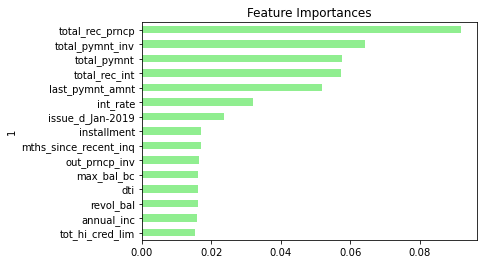

In [23]:
# List the features sorted in descending order by feature importance
# YOUR CODE HERE
importances_df = pd.DataFrame(sorted(zip(model_brf.feature_importances_, X.columns), reverse = True))
importances_df.set_index(importances_df[1], inplace = True)
importances_df.drop(columns = 1, inplace = True)
importances_df.rename(columns = {0: 'Feature Importances'}, inplace=True)
importances_df = importances_df.sort_values(by = 'Feature Importances', ascending = False)
importances_df_top_15 = importances_df.iloc[:15]
importances_df_top_15 = importances_df_top_15.sort_values(by = 'Feature Importances', ascending = True)
importances_df_top_15_plot = importances_df_top_15.plot(kind = 'barh', color = 'lightgreen', title = 'Feature Importances', legend = False)
importances_df_top_15_plot.figure.savefig(Path("../classification_homework_uw_fintech/top_15_features_plot.png"))

### Easy Ensemble Classifier

In [24]:
# Train the EasyEnsembleClassifier
# YOUR CODE HERE
from imblearn.ensemble import EasyEnsembleClassifier
model_eec = EasyEnsembleClassifier(base_estimator=None, n_estimators=100, n_jobs=1,
            random_state=1, replacement=False, sampling_strategy='auto',
            verbose=0, warm_start=False)
model_eec.fit(X_train_scaled, y_train.ravel())
y_eec_pred = model_eec.predict(X_test_scaled)

In [25]:
# Calculated the balanced accuracy score
# YOUR CODE HERE
balanced_accuracy_score(y_test, y_eec_pred)

0.931601605553446

In [26]:
# Display the confusion matrix
# YOUR CODE HERE
confusion_matrix(y_test, y_eec_pred)

array([[   93,     8],
       [  985, 16119]], dtype=int64)

In [28]:
# Print the imbalanced classification report
# YOUR CODE HERE
print(classification_report_imbalanced(y_test, y_eec_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.09      0.92      0.94      0.16      0.93      0.87       101
   low_risk       1.00      0.94      0.92      0.97      0.93      0.87     17104

avg / total       0.99      0.94      0.92      0.97      0.93      0.87     17205



### *Which model had the best balanced accuracy score?*
---
Overall, the EasyEsembleClassifer, a bag of booster learners, had a balanced accuracy score of 0.931601605553446, besting the SMOTE logistic regression of 0.8388510243681058. RandomForest could still be viable, needs more testing on parameters.
### *Which model had the best recall score?*
---
EasyEsembleClassifer again bested SMOTE logistic regression with a total recall score of 0.94 vs. 0.87


### *Which model had the best geometric mean score?*
---
EasyEsembleClassifer has the best geometric mean score with a 0.93 vs. 0.84 by the SMOTE logistic regression.


### *What are the top three features?*
---
EasyEsembleClassifier does not have a feature_importances_ function, but the top 3 features for the BalancedRandomForestClassifier were *total_rec_perncp*, *total_pymnt_inv*, *total_pyment*. These features makes sense as they indicate whether a client pays their loan and what amount determines their level of risk.